In [1]:
!pip install yahoofinance

In [2]:
import yahoofinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.fftpack
%matplotlib inline

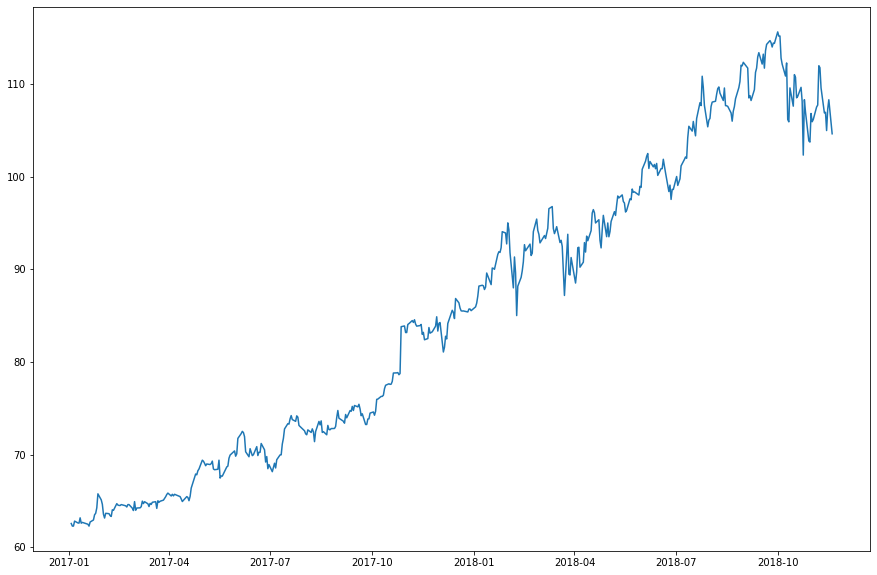

In [3]:
historical = yf.HistoricalPrices('MSFT', '2017-01-01', '2018-11-20')
dfs = historical.to_dfs()
df = dfs['Historical Prices']
df.index = pd.to_datetime(df.index)
fig1 = plt.figure(figsize=(15,10))
plt.plot(df[['Close']])

0.0022716528251539004

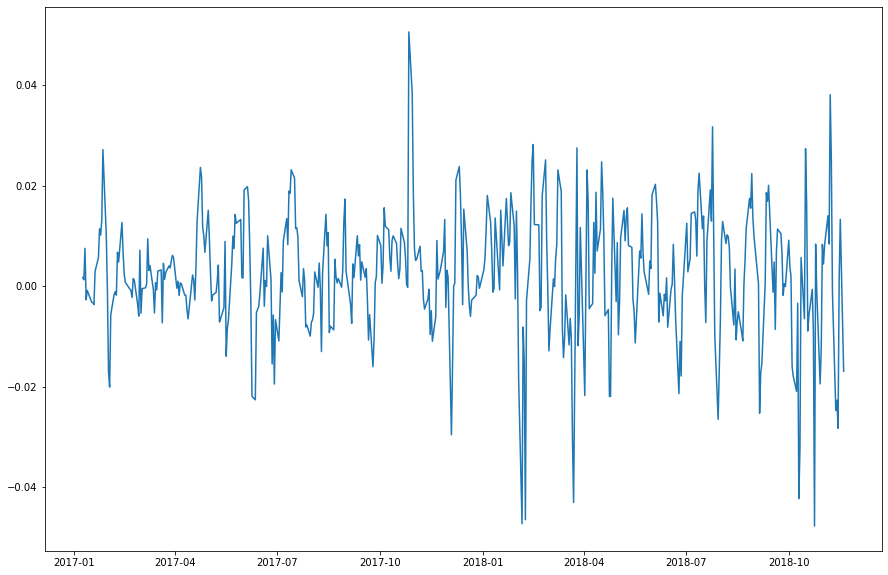

In [4]:
MEAN_WINDOW_DAYS = 5

stkSer = df['Close']

rm = stkSer.rolling(window=MEAN_WINDOW_DAYS)

stkSerNorm = (stkSer - rm.mean())
stkSerNorm = stkSerNorm / rm.mean()

plt.figure(figsize=(15,10))
plt.plot(stkSerNorm)
np.mean(stkSerNorm)


64
0.7893232558704082


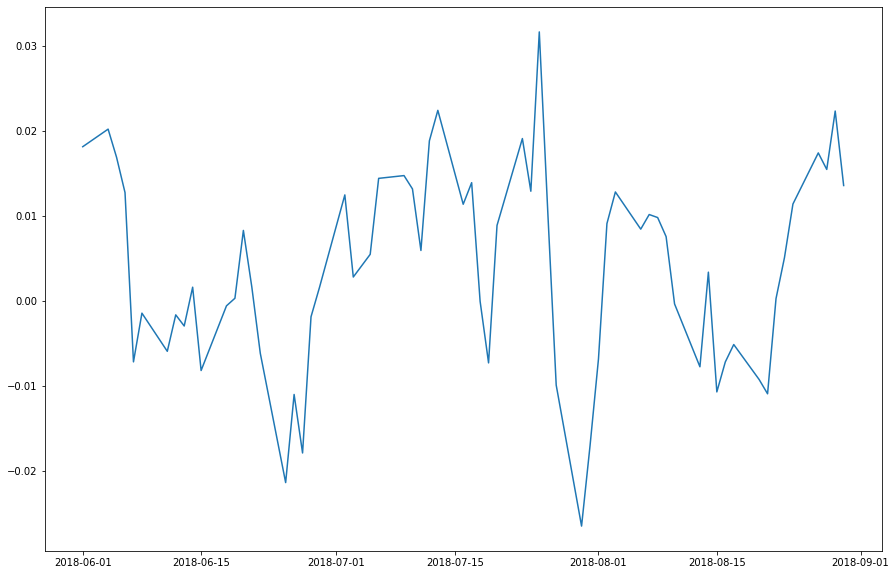

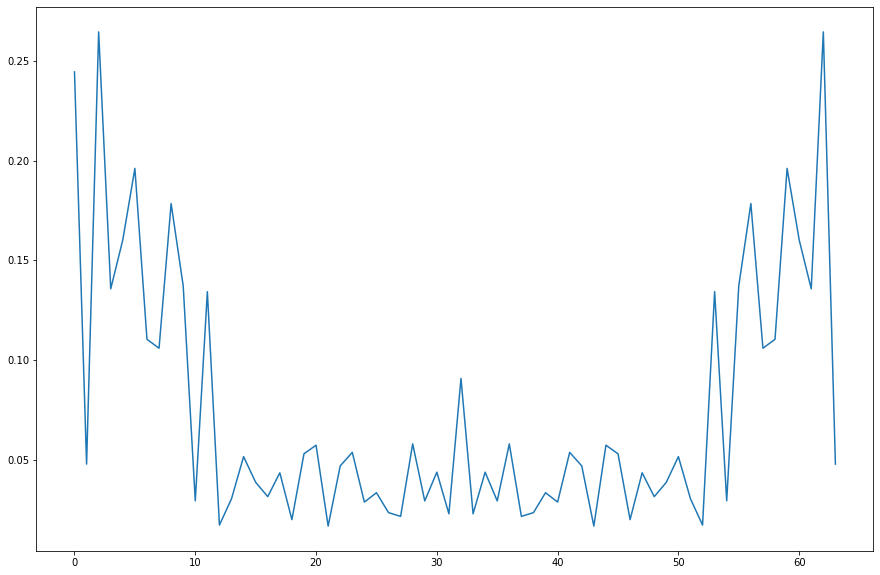

In [5]:
WINDOW_ANALYSIS_DAYS = 90;
#WINDOW_LOW_FREQ = np.round(2*np.pi/(WINDOW_ANALYSIS_DAYS/3));

stkSerNorm = stkSerNorm.dropna();

winStart = pd.to_datetime('2018-06-01')
tDel = pd.to_timedelta(WINDOW_ANALYSIS_DAYS, unit='days')
WinEnd = winStart + tDel

plt.figure(figsize=(15,10))
plt.plot((stkSerNorm[winStart:WinEnd]))

N=len(stkSerNorm[winStart:WinEnd])
print(N)

stkNormFFT = np.fft.fft(stkSerNorm[winStart:WinEnd])

E = abs(np.sqrt( sum(stkNormFFT*np.conj(stkNormFFT))))
print(E)

i = abs(stkNormFFT) > 0
stkNormFFTLowFreq = stkNormFFT[1:10]
 

plt.figure(figsize=(15,10))
plt.plot(abs(stkNormFFT))



In [6]:
# filter periods by cycle duration and amplitude
MAX_PERIOD = WINDOW_ANALYSIS_DAYS / 3
MIN_PERIOD = WINDOW_ANALYSIS_DAYS / 10
MIN_RELATIVE_AMP = 0.3

ks = np.arange(0,N)
k_all = np.arange(0,N)

per = 2*np.pi*N/ks
perAmpNorm = max(abs(stkNormFFT))
perNorm = abs(stkNormFFT) / perAmpNorm


i =  (per > MIN_PERIOD) * (per < MAX_PERIOD) * (perNorm > MIN_RELATIVE_AMP)
k = np.arange(0,N)[i]
perFiltered = per[k]
print(k)
print(perFiltered)
print(perNorm[i])

[32]
[12.56637061]
[0.3428691]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


[12.56637061]


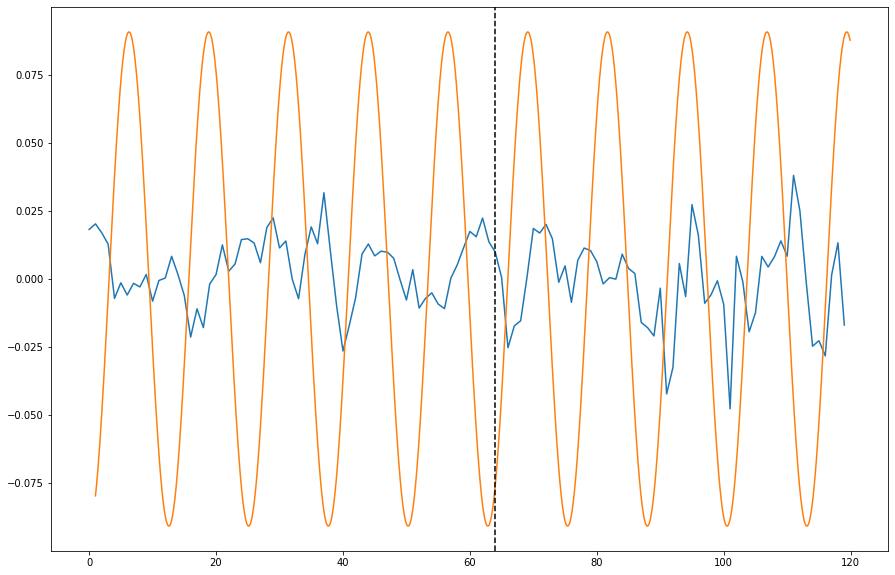

In [7]:
#stkNormDFFTLowFreq = np.fft.ifft(stkNormFFTLowFreq)

orgVals = stkSerNorm[winStart:(WinEnd + tDel)].values
t = np.arange(1, len(orgVals),0.1)


print(2*np.pi*1/(k/N))

A = abs(stkSerNorm.values[k])
Atot = abs(A.sum())
A = A / Atot

C = 0.5*(stkNormFFT[k] + np.conj(stkNormFFT[N-k-1]))

def CycFunc(t):
  res = np.array([])
  for ti in t:
    res = np.append(res,(A*np.real(stkNormFFT[k]*np.exp(1j*ti*k/N))).sum())
  return res; 

plt.figure(figsize=(15,10))
plt.plot(orgVals)
plt.plot(t, CycFunc(t) )
plt.axvline(x=N,color='k', linestyle='--')

0.015079400288939072
-0.011469184095777045
0.026548584384716117


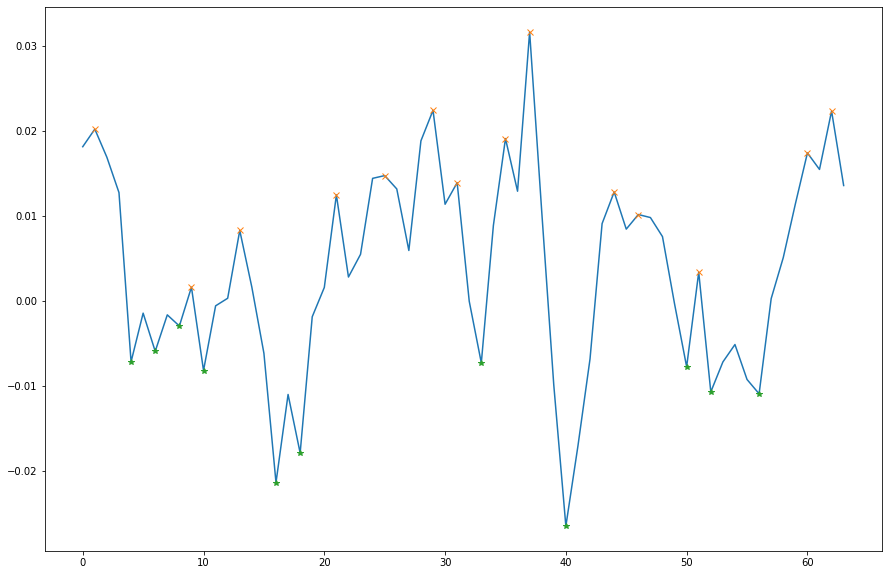

In [12]:

#find average max/min peak to set "sell/buy price"
from scipy.signal import find_peaks


orgValsPast = stkSerNorm[winStart:WinEnd].values

xMax,yMax = find_peaks(orgValsPast, height=0)
yMaxValues = np.array(list(yMax.values()))
yMaxMean = yMaxValues.mean()

xMin,yMin = find_peaks(orgValsPast*(-1), height=0)
yMinValues = np.array(list(yMin.values()))  * (-1)
yMinMean = yMinValues.mean()

meanProfitRel =  yMaxMean - yMinMean

print(yMaxMean)
print(yMinMean)
print(meanProfitRel)


plt.figure(figsize=(15,10))
plt.plot(orgValsPast)
plt.plot(xMax, orgValsPast[xMax],"x")
plt.plot(xMin, orgValsPast[xMin],"*")



In [9]:
C = 0.5*(stkNormFFT[k] + np.conj(stkNormFFT[N-k-1]))
print(C)

print(stkNormFFT[k])
print(stkNormFFT[N-k-1])

[-0.04231505+0.01095892j]
[-0.09074842+0.j]
[0.00611833-0.02191783j]


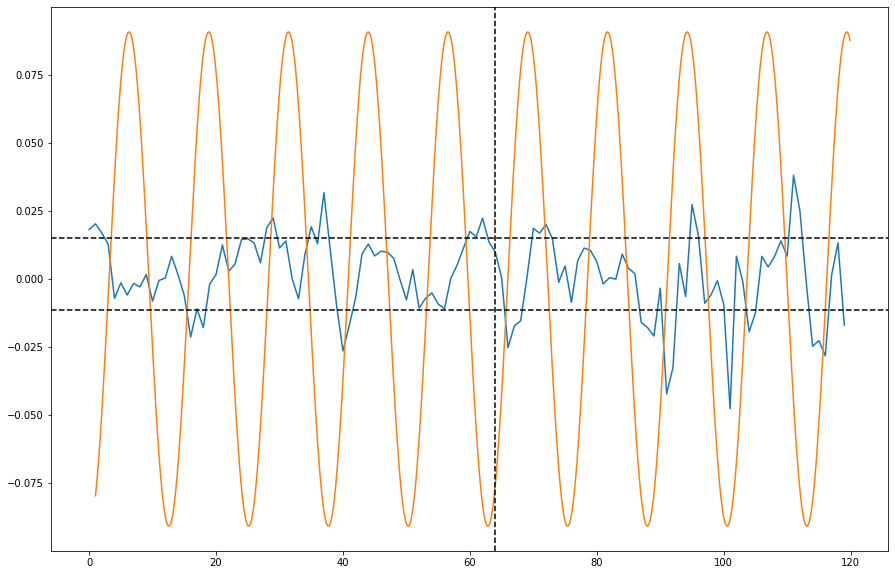

In [13]:
plt.figure(figsize=(15,10))
plt.plot(orgVals)
plt.plot(t, CycFunc(t) )
plt.axvline(x=N,color='k', linestyle='--')
plt.axhline(y=yMaxMean,color='k', linestyle='--')
plt.axhline(y=yMinMean,color='k', linestyle='--')